In [13]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model



# Towards fairness in machine learning with adversarial networks 

## Introduction
From credit ratings to housing allocation, machine learning models are increasingly being used to automate the decision making processes. With the growing impact on society, more and more concerns are being voiced about the loss of transparency, accountability and fairness of the algorithms making the decisions. We as machine learners and data scientists need to step-up our game and look for ways to mitigate emergent discrimination in our models. We need to make sure that our predictions do not disproportionately hurt (or, benefit) people with certain sensitive characteristics (e.g., gender, ethnicity). Luckily, [last year's NIPS conference](https://blog.godatadriven.com/gdd-nips-2017) showed that the field of machine learning is actively investigating how to bring tansparancy and fairness to predictive models. 

Roughly speaking, the effort increasing accountability of predictive models is split into two approaches. The first approach focusses on model interpretability and transparancy by allowing deeper interogation of complex, blackbox models. The second takes the route of constraining and changing the optimization objective such that trained models are more robust and fair in their predictions. In this blog post we will take a look at the second approach and show how adversarial networks can be used for building fairer predictive models. This work is based on the work the 2017 NIPS paper ["Learning to Pivot with Adversarial Networks"](https://papers.nips.cc/paper/6699-learning-to-pivot-with-adversarial-networks) by Louppe et al. 

Most of the code in post itself will be omitted, however you can find jupyter notebook containing all the code [here TODO](...).

## Predicting income levels

The data used for this blog post comes the [adult UCI](https://archive.ics.uci.edu/ml/datasets/Adult) dataset, which is also referred to as "Census Income" dataset. With this data we are going to predict whether or not someone makes over 50K dollar a year. It is not hard to imagine how financial institutions use these kind of models to determine wether or not someone is eligible for a loan, or to set the height of an insurance premium.

We get started by parsing the data into three distinct datasets: features, targets and sensitive attributes. The features $X$ contain the input attributes that the model uses for making the predictions, these are atributtes like age, education level and occupation. The targets $y$ contain the binary class labels that the model needs to predict, where $y\in\left\{income>50K, income\leq 50K\right\}$. The sensitive attributes $Z$ contain the attributes for which we want the prediction to fair, for this we selected race and sex, where $z_{race}\in\left\{black, white\right\}$ and $z_{gender}\in\left\{male, female\right\}$. 

Finally, it is important to note that the three datasets are non-overlapping in terms of attributes, so the sensitive attributes are **not** part of the set of features used for training the model.

In [14]:
# HIDE
def load_ICU_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                    'martial_status', 'occupation', 'relationship', 'race', 'sex', 
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names, 
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  [lambda df: df['race'].isin(['White','Black'])])

    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['race','sex']
    Z = input_data[sensitive_attribs]\
        .assign(race=lambda df: (df['race']=='White').astype(int),
                sex=lambda df: (df['sex']=='Male').astype(int))

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target']=='>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
        .drop(columns=['target','race','sex'])
        .fillna('Unknown')
        .pipe(pd.get_dummies, drop_first=True))
    
    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape} samples")
    print(f"sensitive Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X,y,Z

In [15]:
# load ICU data set
X,y,Z = load_ICU_data('adult.data')

features X: 30940 samples, 94 attributes
targets y: (30940,) samples
sensitive Z: 30940 samples, 2 attributes


Notice that in our dataset contains just over 30K people. Next, we split the data into train and test sets, where the split is 50/50. We use stratified splitting is used to make sure the percentage positive and negative examples are the same in both sets. Also, the feature data is scaled using standard scaling.

In [16]:
# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=1/2, stratify=y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

Now, we are ready to train a neural net on the train data. We use Keras to fit a simple three layer network with ReLU activations and dropout regularization. The output of the network is a single node with sigmoid activation, so it will predict "the probability of the person's income being more than 50K" denoted by $P(income>50K)$.

In [17]:
def nn_classifier(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

clf = nn_classifier(n_features=X_train.shape[1])
history = clf.fit(X_train, y_train, epochs=20, verbose=0)

Finally, we use the trained classfier to make income level predictions on the test data. The prediction performance of the classifier can now be determined by computing the [Area Under the Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) and the accuracy score on resulting predictions.

In [18]:
y_pred = pd.Series(clf.predict(X_test).ravel(), index=y_test.index)
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
print(f"Accuracy: {100*accuracy_score(y_test, (y_pred>0.5)):.1f}%")

ROC AUC: 0.91
Accuracy: 85.1%


With a ROC AUC larger than 0.9 and a prediction accuracy of 85% we can say that our classifier performs pretty well! However, if it is also fair in its prediction remains to be seen.

## Qualitative model fairness

We start our investigation into model fairness by analyzing the predictions our classifier made on the test set. The plots in the figure below show the distributions of the predicted $P(income>50K)$ given each of the sensitive attributes.

In [19]:
# HIDE
def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None):
    fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)   
    legend={'race':['black','white'],
                'sex':['female','male']}
    for idx, attr in enumerate(Z.columns):
        for attr_val in [0,1]:
            ax = sns.distplot(y[Z[attr]==attr_val], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format(legend[attr][attr_val]), 
                              ax=axes[idx])
        ax.set_xlim(0,1)
        ax.set_ylim(0,7)
        ax.set_yticks([])
        ax.set_title("sensitive attibute: {}".format(attr))
        if idx==0:
            ax.set_ylabel('prediction distribution')
        ax.set_xlabel(r'$P({{income>50K}}|z_{{{}}})$'.format(attr))
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                      f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                      f"- Accuracy: {val_metrics['Accuracy']:.1f}"]),
                 fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p-rules:"]+
                                       [f"- {attr}: {p_rules[attr]:.0f}%-rule" for attr in p_rules.keys()]), 
                 fontsize='16')
    fig.tight_layout()
    return fig

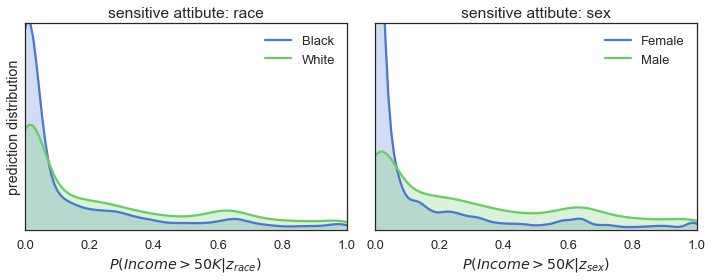

In [20]:
fig = plot_distributions(y_pred, Z_test)

The plots show that for both attributes that the blue prediction distributions have a high peak at low end end of the probability range. This means that when a person is $black$ and/or $female$ there is a much higher probability of predicting an income below 50K, compaired to when someone is $white$ and/or $male$. This shows that the made predictions on the test set are highly biased when it comes to race and sex. Our classifier favours the usual suspects when it comes to assigning higher income levels: white males.

## Quantitave model fairness

In order to get a 'quantitive' measure measure of how fair our classifier is, we take inspiration from the U.S. Equal Employment Opportunity Commission. They use the so-called [80% rule](https://en.wikipedia.org/wiki/Disparate_impact#The_80%_rule) to quantify disparate impact on a group of people of a protected characteristic. In their paper, ["Fairness Constraints: Mechanisms for Fair Classification"](https://arxiv.org/pdf/1507.05259.pdf), Zafar et al. show how a more generic version of this rule, the p%-rule, can be used to quantify fairness of a classifier. This more general rule is defined as follows:

> A classifier that makes a binary class prediction $\hat{y} \in \left\{0,1 \right\}$ given a binary sensitive attribute $z\in \left\{0,1 \right\}$ satifies the p%-rule
if the following inequality holds:
>
>$$\min\left(\frac{P(\hat{y}=1|z=1)}{P(\hat{y}=1|z=0)}, \frac{P(\hat{y}=1|z=0)}{P(\hat{y}=1|z=1)}\right)\geq\frac{p}{100}$$

The rule states that the ratio between the probability of a positive outcome given the sensitive attribute being true and the same probability given the sensitive attribute being false is no less than p:100. So, when a classifier is completely fair it will satify a 100%-rule. In contrast, when it is completely unfair it satisfies a %0-rule. 

In determining model fairness we will follow the U.S. Equal Employment Opportunity Commission and say that a model is fair when it satisfies at least a %80-rule. So, let's compute the %p-rules for the classifier and put a number on its fairness.

In [21]:
# HIDE
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values==1]>threshold if threshold else y_pred[z_values==1]
    y_z_0 = y_pred[z_values==0]>threshold if threshold else y_pred[z_values==0]
    odds = y_z_1.mean()/y_z_0.mean()
    return np.min([odds, 1/odds])*100

In [22]:
print("The classifier satifies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['sex']):.0f}%-rule")

The classifier satifies the following %p-rules:
	given attribute race; 47%-rule
	given attribute sex;  35%-rule


We find that for both sensitive attributes the classifier satisfies a p%-rule that is significantly lower than 80%. This supports our earlier conclusion; our classifier is unfair in making its predictions. 

## Dealing with bias

It is important to stress that fixing model fairness is not straightforward. One might be tempted to think that merely excluding sensitive information from the data is enough to obtain a model that is fair. However, remember that the sensitive attributes race and sex were actually **not** included in the features that were used for training our classifier. So, even though the model did not have access to sensitive information during training, it still ended up discriminating agains women and black people.

So, how did can a model end-up behaving like this? Well, it is often due to the fact that the data on which it was trained is deeply biased against specific groups of peoples. Consider the images below for example, these were taken from [this](https://arxiv.org/pdf/1711.11443.pdf) paper and show two classification errors made by a deep learning classifier. This model was trained on a dataset in which some ethenicities are overrepresented by specific classes; black people are primarily depicted playing basketball and asian people playing ping-pong. This result is a baised model that can make quite offensive mistakes.

<center><img src="images/missclassified_images.png" alt="GAN Images" width="250"/></center>

The dataset that we used for training our classifier, the UCI dataset, is also deeply biased. It is based on 1994 census data, a time in which income inquality was just as much of an issue as it is nowadays. As a result, most of the 'high' earners in the data are white males. As we saw in the previous sections, readily pick-up by our models making its behavior just as biased as the data on which it was trained. 

Now that we know a bit more about the causes of the dicriminatory behavior of our model, how can we go about fixing it? In general, there are two approaches we can take. First, we somehow de-bias our dataset, for example by adding additional data that comes from a more representative sample. Second, we constrain the model such that is forced into making fairer predictions. Next, we will show how afverserial networks can help in taking the second approach.

## Adverserial networks

In 2014, Goodfellow et al. published their seminal [paper](https://arxiv.org/abs/1406.2661) on Generative Adversarial Networks (GANs). In the paper, GANs are introduced as a system of two neural networks, a generative model and an adverseral classfier, which are competing with each other in a zero-sum game. Each net has its own specific goal that it tries to optimize during the game. The generative model focusses on producing samples that are indistinguishable from real data, while the adverserial classifier tries to identify if samples came from the generative model or from the real data. Both networks are trained simultanously in such a way that the generative model improves at produce realistic samples, while the adverserial becomes better at spotting the 'fakes' from the real samples. Below an example of a set of pictures that were generated by a generative model of a GAN.

<center><img src="images/gan_examples.png" alt="GAN Images" width="500"/></center>

The work of Louppe et al shows that the GAN framework can be repurposed to constrain a classifier such that it makes fairer prediction. In the paper they state that it can be used for enforcing that the classifier, denoted by $f(X)$, is a [pivot](https://en.wikipedia.org/wiki/Pivotal_quantity) with respect to $Z$. Meaning that the classifiers probability distribution no longer depends on the sensitive attributes

\
it enforces that the classifier, denoted as $f(X)$, such that is a  with respect to the senstive attributes $Z$.



adversarial networks for enforcing that f(X) is a pivot with respect to Z.

We introduce a flexible learning procedure based on adversarial networks (Goodfellow et al., 2014) for enforcing that
f(X) is a pivot with respect to Z. We derive theoretical results proving that the procedure converges
towards a model that is both optimal and statistically independent of the nuisance parameters (if
that model exists) or for which one can tune a trade-off between accuracy and robustness (e.g., as
driven by a higher level objective)

In [23]:
# HIDE

class FairClassifier(object):
    
    def __init__(self, n_features, n_sensitive, lambdas):
        self.lambdas = lambdas
        
        clf_inputs = Input(shape=(n_features,))
        adv_inputs = Input(shape=(1,))
        
        clf_net = self._create_clf_net(clf_inputs)
        adv_net = self._create_adv_net(adv_inputs, n_sensitive)
        self._trainable_clf_net = self._make_trainable(clf_net)
        self._trainable_adv_net = self._make_trainable(adv_net)
        self._clf = self._compile_clf(clf_net)
        self._clf_w_adv = self._compile_clf_w_adv(clf_inputs, clf_net, adv_net)
        self._adv = self._compile_adv(clf_inputs, clf_net, adv_net, n_sensitive)
        self._val_metrics = None
        self._fairness_metrics = None
        
        self.predict = self._clf.predict
        
        
    def _make_trainable(self, net):
        def make_trainable(flag):
            net.trainable = flag
            for layer in net.layers:
                layer.trainable = flag
        return make_trainable
        
    def _create_clf_net(self, inputs):
        dense1 = Dense(32, activation='relu')(inputs)
        dropout1 = Dropout(0.2)(dense1)
        dense2 = Dense(32, activation='relu')(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        dense3 = Dense(32, activation='relu')(dropout2)
        dropout3 = Dropout(0.2)(dense3)
        outputs = Dense(1, activation='sigmoid', name='y')(dropout3)
        return Model(inputs=[inputs], outputs=[outputs])
        
    def _create_adv_net(self, inputs, n_sensitive):
        dense1 = Dense(32, activation='relu')(inputs)
        dense2 = Dense(32, activation='relu')(dense1)
        dense3 = Dense(32, activation='relu')(dense2)
        outputs = [Dense(1, activation='sigmoid')(dense3) for _ in range(n_sensitive)]
        return Model(inputs=[inputs], outputs=outputs)

    def _compile_clf(self, clf_net):
        clf = clf_net
        self._trainable_clf_net(True)
        clf.compile(loss='binary_crossentropy', optimizer='adam')
        return clf
        
    def _compile_clf_w_adv(self, inputs, clf_net, adv_net):
        clf_w_adv = Model(inputs=[inputs], outputs=[clf_net(inputs)]+adv_net(clf_net(inputs)))
        self._trainable_clf_net(True)
        self._trainable_adv_net(False)
        loss_weights = [1.]+[-lambda_param for lambda_param in self.lambdas]
        clf_w_adv.compile(loss=['binary_crossentropy']*(len(loss_weights)), 
                          loss_weights=loss_weights,
                          optimizer='adam')
        return clf_w_adv

    def _compile_adv(self, inputs, clf_net, adv_net, n_sensitive):
        adv = Model(inputs=[inputs], outputs=adv_net(clf_net(inputs)))
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        adv.compile(loss=['binary_crossentropy']*n_sensitive, optimizer='adam')
        return adv

    def _compute_class_weights(self, data_set):
        class_values  = [0,1]
        class_weights = []
        if len(data_set.shape)==1:
            balanced_weights =  compute_class_weight('balanced', class_values, data_set)
            class_weights.append(dict(zip(class_values, balanced_weights)))
        else:
            n_attr =  data_set.shape[1]
            for attr_idx in range(n_attr):
                balanced_weights =  compute_class_weight('balanced', class_values, np.array(data_set)[:,attr_idx])
                class_weights.append(dict(zip(class_values, balanced_weights)))
        return class_weights
    
    def _compute_target_class_weights(self, y):
        class_values  = [0,1]
        balanced_weights =  compute_class_weight('balanced', class_values, y)
        class_weights = {'y': dict(zip(class_values, balanced_weights))}
        return class_weights
        
    def pretrain(self, x, y, z, epochs=10, verbose=0):
        self._trainable_clf_net(True)
        self._clf.fit(x, y, epochs=epochs, verbose=verbose)
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        class_weight_adv = self._compute_class_weights(z)
        self._adv.fit(x, np.hsplit(z, z.shape[1]), class_weight=class_weight_adv, 
                      epochs=epochs, verbose=verbose)
        
    def fit(self, x, y, z, validation_data=None, n_iter=250, batch_size=128, weight_sensitive_classes=True, save_figs=False):
        n_sensitive = z.shape[1]
        if validation_data is not None:
            x_val, y_val, z_val = validation_data

        class_weight_adv = self._compute_class_weights(z)
        class_weight_clf_w_adv = [{0:1.,1:1.}]+class_weight_adv
        self._val_metrics = pd.DataFrame()
        self._fairness_metrics = pd.DataFrame()  
        for idx in range(n_iter):
            if validation_data is not None:
                y_pred = pd.Series(clf.predict(x_val).ravel(), index=y_val.index)
                self._val_metrics.loc[idx, 'ROC AUC'] = roc_auc_score(y_val, y_pred)
                self._val_metrics.loc[idx, 'Accuracy'] = (accuracy_score(y_val, (y_pred>0.5))*100)
                for sensitive_attr in z_val.columns:
                    self._fairness_metrics.loc[idx, sensitive_attr] = p_rule(y_pred, z_val[sensitive_attr])
                display.clear_output(wait=True)
                plot_distributions(y_pred, z_val, idx+1, self._val_metrics.loc[idx], self._fairness_metrics.loc[idx])
                if save_figs:
                    !rm output/*.png
                    plt.savefig(f'output/{idx+1:08d}.png', bbox_inches='tight')
                plt.show(plt.gcf())
                
            # train classifier
            self._trainable_clf_net(True)
            self._trainable_adv_net(False)
            indices = np.random.permutation(len(x))[:batch_size]
            self._clf_w_adv.train_on_batch(x.values[indices], 
                                           [y.values[indices]]+np.hsplit(z.values[indices],n_sensitive),
                                           class_weight=class_weight_clf_w_adv)
            
            # train adverserial
            self._trainable_clf_net(False)
            self._trainable_adv_net(True)
            self._adv.fit(x, np.hsplit(z, z.shape[1]), batch_size=batch_size, class_weight=class_weight_adv,
                          epochs=1, verbose=0)

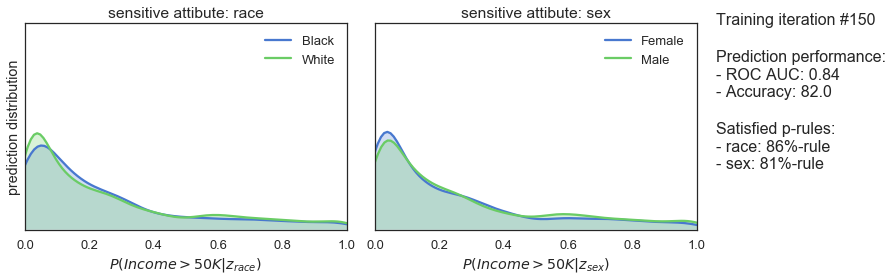

In [24]:
clf = FairClassifier(X_train.shape[1], Z_train.shape[1], [100., 30.])
clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=5)
clf.fit(X_train, y_train, Z_train, validation_data=(X_test, y_test, Z_test), n_iter=150, save_figs=True)

In [25]:
!convert -loop 0 -delay 0 output/*.png -delay 500 output/00000150.png training.gif